In [650]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

In [651]:
submission_files = [   
    
    '/opt/ml/level2_objectdetection-cv-01/mmdetection/Ensemble/submission_battery.csv',
    '/opt/ml/level2_objectdetection-cv-01/mmdetection/Ensemble/submission_ensemble0.7,0.5.csv',
    '/opt/ml/level2_objectdetection-cv-01/mmdetection/work_dirs/dcn/submission_epoch_17.csv'

    ]
submission_df = [pd.read_csv(file) for file in submission_files]

In [652]:
submission_df

[      Unnamed: 0 PredictionString       image_id
 0              0              NaN  test/0000.jpg
 1              1              NaN  test/0001.jpg
 2              2              NaN  test/0002.jpg
 3              3              NaN  test/0003.jpg
 4              4              NaN  test/0004.jpg
 ...          ...              ...            ...
 4866        4866              NaN  test/4866.jpg
 4867        4867              NaN  test/4867.jpg
 4868        4868              NaN  test/4868.jpg
 4869        4869              NaN  test/4869.jpg
 4870        4870              NaN  test/4870.jpg
 
 [4871 rows x 3 columns],
       Unnamed: 0                                   PredictionString  \
 0              0  7 0.9990944862365723 121.38797760009766 418.63...   
 1              1  5 0.98931366 353.46667 250.30507 747.3043 694....   
 2              2  1 0.9923442006111145 425.26312255859375 268.01...   
 3              3  9 0.9903262257575989 107.30169677734375 263.53...   
 4          

In [653]:
annotation = '../../dataset/test.json'
coco = COCO(annotation)
image_ids = submission_df[0]['image_id'].tolist()
print(image_ids)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
['test/0000.jpg', 'test/0001.jpg', 'test/0002.jpg', 'test/0003.jpg', 'test/0004.jpg', 'test/0005.jpg', 'test/0006.jpg', 'test/0007.jpg', 'test/0008.jpg', 'test/0009.jpg', 'test/0010.jpg', 'test/0011.jpg', 'test/0012.jpg', 'test/0013.jpg', 'test/0014.jpg', 'test/0015.jpg', 'test/0016.jpg', 'test/0017.jpg', 'test/0018.jpg', 'test/0019.jpg', 'test/0020.jpg', 'test/0021.jpg', 'test/0022.jpg', 'test/0023.jpg', 'test/0024.jpg', 'test/0025.jpg', 'test/0026.jpg', 'test/0027.jpg', 'test/0028.jpg', 'test/0029.jpg', 'test/0030.jpg', 'test/0031.jpg', 'test/0032.jpg', 'test/0033.jpg', 'test/0034.jpg', 'test/0035.jpg', 'test/0036.jpg', 'test/0037.jpg', 'test/0038.jpg', 'test/0039.jpg', 'test/0040.jpg', 'test/0041.jpg', 'test/0042.jpg', 'test/0043.jpg', 'test/0044.jpg', 'test/0045.jpg', 'test/0046.jpg', 'test/0047.jpg', 'test/0048.jpg', 'test/0049.jpg', 'test/0050.jpg', 'test/0051.jpg', 'test/0052.jpg', 'test/0053.jpg'

In [662]:
prediction_strings = []
file_names = []
iou_thr = 0.8
weights = [1.5,1.5,2]

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        if predict_list==['nan']:
            boxes_list.append([])
            scores_list.append([])
            labels_list.append([])

        if len(predict_list)==0 or len(predict_list)==1:
            continue
        
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))

    
    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list,
                                                       weights=weights, iou_thr=iou_thr,
                                                       skip_box_thr=0.3,
                                                       conf_type="avg")
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '

    prediction_strings.append(prediction_string)
    file_names.append(image_id)

/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


In [663]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./Ensemble/submission_ensemble4.csv')

submission.head()

,PredictionString,image_id
0,7 0.6660629908243815 121.91975402832031 412.35...,test/0000.jpg
1,5 0.6595424546135796 353.4666748046875 250.305...,test/0001.jpg
2,1 0.6615628136528863 422.89678955078125 268.03...,test/0002.jpg
3,9 0.6602174970838759 84.9439926147461 269.4955...,test/0003.jpg
4,1 0.5970120429992676 200.2844696044922 288.705...,test/0004.jpg


In [664]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./Ensemble/submission_ensemble.csv')

submission.head()

,PredictionString,image_id
0,7 0.6660629908243815 121.91975402832031 412.35...,test/0000.jpg
1,5 0.6595424546135796 353.4666748046875 250.305...,test/0001.jpg
2,1 0.6615628136528863 422.89678955078125 268.03...,test/0002.jpg
3,9 0.6602174970838759 84.9439926147461 269.4955...,test/0003.jpg
4,1 0.5970120429992676 200.2844696044922 288.705...,test/0004.jpg


In [665]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [666]:
img_idx = 0
print(image_ids)

['test/0000.jpg', 'test/0001.jpg', 'test/0002.jpg', 'test/0003.jpg', 'test/0004.jpg', 'test/0005.jpg', 'test/0006.jpg', 'test/0007.jpg', 'test/0008.jpg', 'test/0009.jpg', 'test/0010.jpg', 'test/0011.jpg', 'test/0012.jpg', 'test/0013.jpg', 'test/0014.jpg', 'test/0015.jpg', 'test/0016.jpg', 'test/0017.jpg', 'test/0018.jpg', 'test/0019.jpg', 'test/0020.jpg', 'test/0021.jpg', 'test/0022.jpg', 'test/0023.jpg', 'test/0024.jpg', 'test/0025.jpg', 'test/0026.jpg', 'test/0027.jpg', 'test/0028.jpg', 'test/0029.jpg', 'test/0030.jpg', 'test/0031.jpg', 'test/0032.jpg', 'test/0033.jpg', 'test/0034.jpg', 'test/0035.jpg', 'test/0036.jpg', 'test/0037.jpg', 'test/0038.jpg', 'test/0039.jpg', 'test/0040.jpg', 'test/0041.jpg', 'test/0042.jpg', 'test/0043.jpg', 'test/0044.jpg', 'test/0045.jpg', 'test/0046.jpg', 'test/0047.jpg', 'test/0048.jpg', 'test/0049.jpg', 'test/0050.jpg', 'test/0051.jpg', 'test/0052.jpg', 'test/0053.jpg', 'test/0054.jpg', 'test/0055.jpg', 'test/0056.jpg', 'test/0057.jpg', 'test/0058.jp

In [667]:

len(scores)

3

In [668]:
img_idx = 0

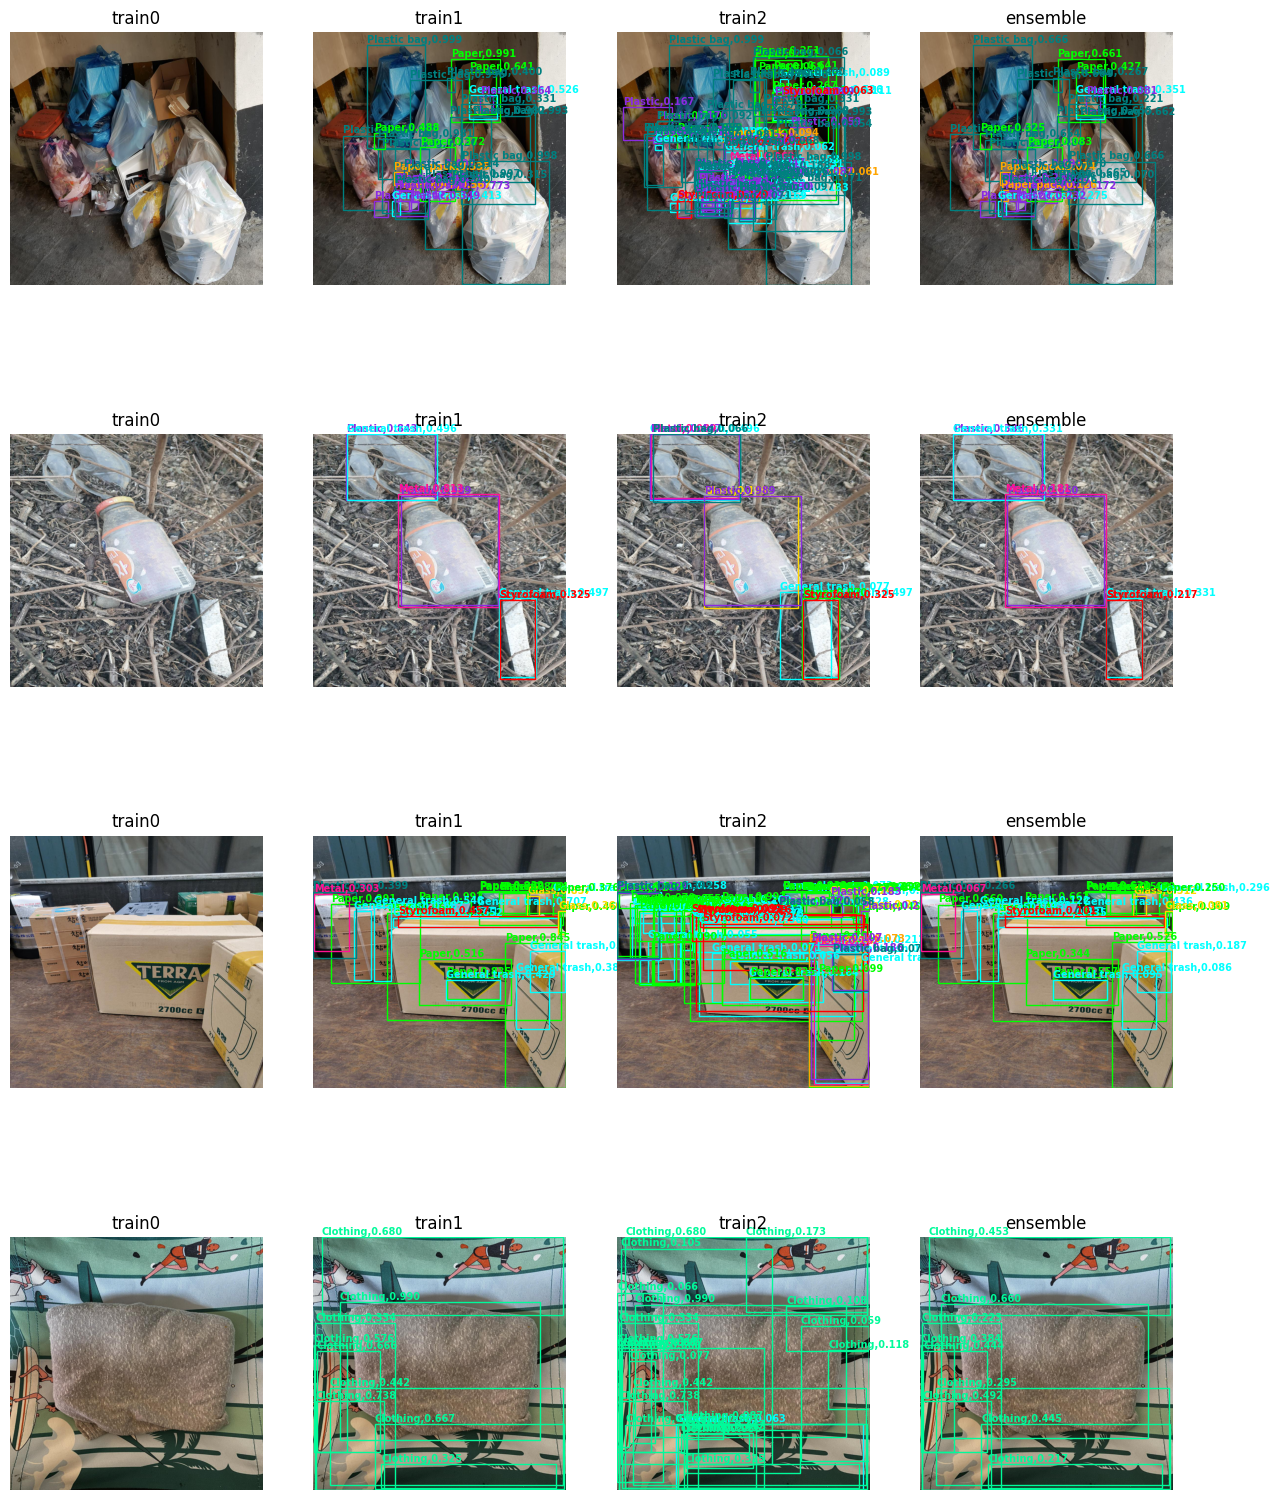

In [669]:
colors = ['cyan', 'lime', 'orange', 'deeppink', 'gold', 'blueviolet', 'red', 'teal', 'hotpink', 'mediumspringgreen']
category = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

colors = ['cyan', 'lime', 'orange', 'deeppink', 'gold', 'blueviolet', 'red', 'teal', 'hotpink', 'mediumspringgreen']

fig, axes = plt.subplots(4, 4, figsize=(15, 20))

informations = {f"train{idx}" : df for idx, df in enumerate(submission_df)}
informations['ensemble'] = submission
for y, image_id in enumerate(image_ids[4*img_idx:4*img_idx+4]):
    img_path = os.path.join("../../dataset/", image_id)
                            
    for i, (name, df) in enumerate(informations.items()):
        predict_list = str(df[df['image_id'] == image_id]['PredictionString'].tolist()[0]).split()
        if predict_list == ['nan']:
            predict_list = []
        x = i % 4
        img = Image.open(img_path)

        axes[y][x].imshow(img)
        axes[y][x].axis('off')
        axes[y][x].set_title(name)

        for idx in range(len(predict_list)//6):
            label, confidence, x_min, y_min, x_max, y_max = int(predict_list[6*idx + 0]), float(predict_list[6*idx + 1]), float(predict_list[6*idx + 2]), float(predict_list[6*idx + 3]), float(predict_list[6*idx + 4]), float(predict_list[6*idx + 5])
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[label], facecolor='none')
            axes[y][x].add_patch(rect)
            axes[y][x].text(x_min, y_min-10, f"{category[label]},{confidence:.3f}", color=colors[label], fontsize=7, weight='bold')
fig.set_tight_layout
img_idx += 1
plt.show()